🔎 목적

1D 열화상 벡터에서 제품 중심 또는 유효 영역만 추출

정규화(Normalization) 를 통해 단위 차이 제거

후속 품질 진단을 위한 데이터 표준화 기반 마련

📌 1단계: 라이브러리 및 데이터 불러오기

In [20]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import matplotlib as mpl
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams['font.family'] = 'AppleGothic'  # Mac 한글폰트
mpl.rcParams['axes.unicode_minus'] = False

# 경로 설정
data_dir = Path("..") / "raw_data"
label_path = Path("..") / "labels" / "left_label.json"

# 데이터 로드
df_data = pd.read_csv(data_dir / "left_data.csv", header=None)
with open(label_path) as f:
    label_list = json.load(f)
df_label = pd.DataFrame(label_list, columns=["thickness"])
df_label["id"] = df_label.index

# 기준 기반 라벨
def get_label(thick):
    return "OK" if 0.8 < thick < 1.5 else "NG"
df_label["label"] = df_label["thickness"].apply(get_label)


📌 2단계: 중심 구간(ROI) 추출

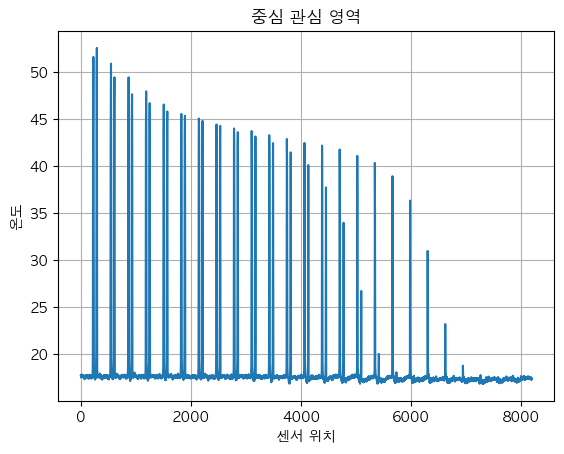

In [22]:
def extract_roi(vector, ratio=0.1):
    length = len(vector)
    margin = int(length * (1-ratio)/2)
    return vector[margin:margin + int(length * ratio)]

sample_vector = df_data.iloc[0].values
roi_vector = extract_roi(sample_vector)

plt.plot(roi_vector)
plt.title("중심 관심 영역")
plt.xlabel("센서 위치")
plt.ylabel("온도")
plt.grid(True)
plt.show()

In [23]:
roi_df = df_data.apply(lambda row:extract_roi(row.values), axis=1, result_type='expand')
roi_df.head()

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,17.717,17.695,17.717,17.738,17.565,17.803,17.652,17.501,17.652,17.695,...,17.457,17.371,17.414,17.436,17.349,17.262,17.349,17.349,17.414,17.349
1,17.911,17.889,17.954,17.997,17.889,18.019,17.846,17.760,17.911,17.932,...,17.652,17.760,17.587,17.674,17.652,17.695,17.674,17.630,17.738,17.652
2,17.436,17.501,17.501,17.501,17.501,17.436,17.501,17.436,17.544,17.544,...,17.457,17.371,17.501,17.414,17.436,17.479,17.479,17.587,17.392,17.414
3,17.587,17.587,17.630,17.609,17.609,17.609,17.695,17.565,17.652,17.781,...,17.652,17.652,17.630,17.609,17.738,17.695,17.630,17.479,17.587,17.522
4,17.544,17.565,17.501,17.479,17.630,17.565,17.565,17.565,17.587,17.587,...,17.392,17.392,17.392,17.392,17.587,17.457,17.436,17.392,17.457,17.349


📌 3단계: 정규화 (Min-Max)

In [24]:
def normalize(vec):
    return (vec - np.min(vec)) / (np.max(vec) - np.min(vec))

norm_df = roi_df.apply(lambda row: normalize(row.values), axis=1, result_type = 'expand')
norm_df.head()


,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.024899,0.024284,0.024899,0.025487,0.020647,0.027305,0.023081,0.018856,0.023081,0.024284,...,0.017625,0.015219,0.016422,0.017038,0.014604,0.012170,0.014604,0.014604,0.016422,0.014604
1,0.023218,0.022597,0.024433,0.025648,0.022597,0.026269,0.021382,0.018953,0.023218,0.023812,...,0.015903,0.018953,0.014067,0.016524,0.015903,0.017117,0.016524,0.015281,0.018332,0.015903
2,0.018075,0.019877,0.019877,0.019877,0.019877,0.018075,0.019877,0.018075,0.021069,0.021069,...,0.018657,0.016273,0.019877,0.017465,0.018075,0.019267,0.019267,0.022261,0.016855,0.017465
3,0.021102,0.021102,0.022264,0.021696,0.021696,0.021696,0.024020,0.020507,0.022858,0.026344,...,0.022858,0.022858,0.022264,0.021696,0.025182,0.024020,0.022264,0.018184,0.021102,0.019346
4,0.021341,0.021930,0.020133,0.019515,0.023755,0.021930,0.021930,0.021930,0.022548,0.022548,...,0.017072,0.017072,0.017072,0.017072,0.022548,0.018898,0.018308,0.017072,0.018898,0.015865


📌 4단계: OK vs NG 평균 벡터 시각화

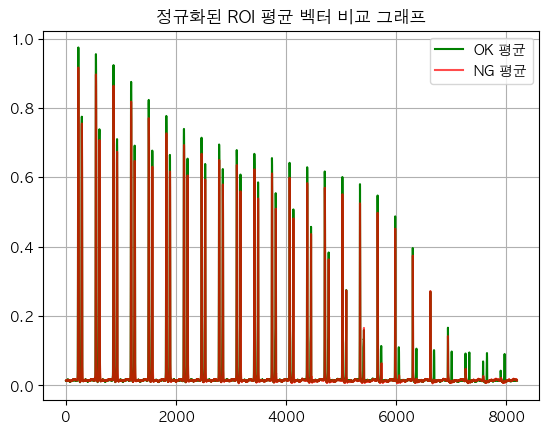

In [25]:
ok_idx = df_label[df_label["label"] == "OK"].index
ng_idx = df_label[df_label["label"] == "NG"].index

ok_mean = norm_df.loc[ok_idx].mean()
ng_mean = norm_df.loc[ng_idx].mean()

plt.plot(ok_mean, label="OK 평균", color="green")
plt.plot(ng_mean, label="NG 평균", color="red", alpha=0.7)

plt.title("정규화된 ROI 평균 벡터 비교 그래프")
plt.legend()
plt.grid(True)
plt.show()
